# Comparaison statistique des performances de XG Boost en OOD et ID

In [53]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import encode_categorical_feature, get_simplified_names
from src.experiments import (
    prepare_data_random_split, prepare_data_hide_one_per_class,
    prepare_data_hide_class, train_xgboost_models, get_hidden_products_info
)
from src.visu import plot_ml_results

# Charger les données
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Définir les variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convertir les colonnes numériques
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Obtenir les noms simplifiés
simplified_names = get_simplified_names()

print(f"Données chargées: {len(data)} observations")


Données chargées: 6376 observations


## Test de Robustesse Hors-Distribution (OOD)

Tester la généralisation du modèle en cachant des produits/classes lors de l'entraînement et en évaluant sur les données retenues.


### Baseline: Split Aléatoire Intradistribution (ID)


In [38]:
# Baseline ID avec stratification par Nom - ÉVALUATION MULTI-SEEDS (10 seeds)
from sklearn.model_selection import train_test_split

ID_all_runs = []

print("\n" + "="*80)
print("BASELINE: Split Aléatoire Intradistribution (ID) avec Stratification par Nom")
print("Évaluation Multi-Seeds (10 seeds pour comparabilité avec OOD)")
print("="*80)
print("Configuration: 10 seeds aléatoires\n")

# Exécuter ID avec 10 seeds différents
for seed in range(10):
    # Obtenir tous les indices
    all_indices = np.arange(len(data))
    
    # Split stratifié par Nom
    train_indices, test_indices = train_test_split(
        all_indices,
        test_size=0.2,
        random_state=seed,  # Seed différente à chaque fois
        stratify=data['Nom'].values
    )
    
    X_train_ID = data.iloc[train_indices][vars_expl].reset_index(drop=True)
    X_test_ID = data.iloc[test_indices][vars_expl].reset_index(drop=True)
    y_train_ID = data.iloc[train_indices][vars_cibles].reset_index(drop=True)
    y_test_ID = data.iloc[test_indices][vars_cibles].reset_index(drop=True)
    
    results_ID, metrics_ID, models_ID = train_xgboost_models(
        X_train_ID, X_test_ID, y_train_ID, y_test_ID,
        vars_cibles, simplified_names, random_state=seed
    )
    
    r2_score = metrics_ID['R2_variance_weighted']
    ID_all_runs.append({
        'Seed': seed,
        'R² Variance Weighted': r2_score
    })
    
    print(f"Seed {seed}: R² = {r2_score:.4f}")

# Convertir en DataFrame
ID_df = pd.DataFrame(ID_all_runs)

# Calculer les statistiques
mean_r2_id = ID_df['R² Variance Weighted'].mean()
std_r2_id = ID_df['R² Variance Weighted'].std()
ci_95_id = 1.96 * std_r2_id / np.sqrt(len(ID_df))

print(f"\nSTATISTIQUES BASELINE ID")
print(f"  Moyenne R²: {mean_r2_id:.4f}")
print(f"  Écart-type: {std_r2_id:.4f}")
print(f"  IC 95%: [{mean_r2_id - ci_95_id:.4f}, {mean_r2_id + ci_95_id:.4f}]")
print(f"  Nombre d'exécutions: {len(ID_df)}")



BASELINE: Split Aléatoire Intradistribution (ID) avec Stratification par Nom
Évaluation Multi-Seeds (10 seeds pour comparabilité avec OOD)
Configuration: 10 seeds aléatoires

Seed 0: R² = 0.9903
Seed 1: R² = 0.9897
Seed 2: R² = 0.9909
Seed 3: R² = 0.9908
Seed 4: R² = 0.9897
Seed 5: R² = 0.9910
Seed 6: R² = 0.9915
Seed 7: R² = 0.9913
Seed 8: R² = 0.9913
Seed 9: R² = 0.9915

STATISTIQUES BASELINE ID
  Moyenne R²: 0.9908
  Écart-type: 0.0007
  IC 95%: [0.9904, 0.9912]
  Nombre d'exécutions: 10


### Scénario OOD 1: Cacher 1 Produit Aléatoire (Multiples Seeds & Produits)
**Protocole Amélioré:**
- Multiples seeds (10 exécutions) pour la robustesse statistique
- Pour chaque seed, tester 3 produits différents cachés et moyenner les résultats
- Calculer les intervalles de confiance à 95%
- Effectuer des tests t appairés vs baseline ID pour évaluer la significativité


In [39]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Scénario OOD 1: Cacher 1 produit aléatoire avec MULTIPLES SEEDS et PRODUITS
# Paramètres
num_seeds = 10
products_per_seed = min(3, len(data['Nom'].unique()))  # Tester 3 produits différents par seed (ou moins si moins de produits)

ood1_all_runs = []
ood1_seed_results = {}

print("\n" + "="*80)
print("SCÉNARIO OOD 1: Cacher 1 Produit Aléatoire - ÉVALUATION ROBUSTE")
print("="*80)
print(f"Configuration: {num_seeds} seeds × {products_per_seed} produits par seed")
print(f"Total d'exécutions: {num_seeds * products_per_seed}\n")

unique_noms = data['Nom'].unique()

for seed in range(num_seeds):
    rng = np.random.RandomState(seed)
    seed_results = []
    
    # Sélectionner N produits différents à cacher pour ce seed
    products_to_test = rng.choice(unique_noms, size=products_per_seed, replace=False)
    
    for nom_to_hide in products_to_test:
        X_train_ood1 = data[data['Nom'] != nom_to_hide][vars_expl].reset_index(drop=True)
        X_test_ood1 = data[data['Nom'] == nom_to_hide][vars_expl].reset_index(drop=True)
        y_train_ood1 = data[data['Nom'] != nom_to_hide][vars_cibles].reset_index(drop=True)
        y_test_ood1 = data[data['Nom'] == nom_to_hide][vars_cibles].reset_index(drop=True)
        
        if len(X_test_ood1) >= 1:
            results_ood1, metrics_ood1, models_ood1 = train_xgboost_models(
                X_train_ood1, X_test_ood1, y_train_ood1, y_test_ood1,
                vars_cibles, simplified_names, random_state=seed
            )
            
            r2_score = metrics_ood1['R2_variance_weighted']
            performance_drop = r2_score - metrics_ID['R2_variance_weighted']
            
            seed_results.append({
                'Seed': seed,
                'Hidden Product': nom_to_hide,
                'Test Size': len(X_test_ood1),
                'R² Variance Weighted': r2_score,
                'Performance Drop': performance_drop
            })
            ood1_all_runs.append({
                'Seed': seed,
                'Hidden Product': nom_to_hide,
                'R² Variance Weighted': r2_score,
                'Performance Drop': performance_drop
            })
    
    ood1_seed_results[seed] = seed_results
    
    # Afficher la progression
    seed_avg_r2 = np.mean([r['R² Variance Weighted'] for r in seed_results])
    print(f"Seed {seed:2d}: R² moyen = {seed_avg_r2:.4f} (produits testés: {', '.join(products_to_test)})")

# Convertir en DataFrame pour l'analyse
ood1_df = pd.DataFrame(ood1_all_runs)

print("\n" + "="*80)
print("SCÉNARIO 1: RÉSUMÉ STATISTIQUE")
print("="*80)

# Calculer les statistiques
mean_r2 = ood1_df['R² Variance Weighted'].mean()
std_r2 = ood1_df['R² Variance Weighted'].std()
ci_95 = 1.96 * std_r2 / np.sqrt(len(ood1_df))  # Intervalle de confiance 95%
min_r2 = ood1_df['R² Variance Weighted'].min()
max_r2 = ood1_df['R² Variance Weighted'].max()

mean_drop = ood1_df['Performance Drop'].mean()
std_drop = ood1_df['Performance Drop'].std()
ci_95_drop = 1.96 * std_drop / np.sqrt(len(ood1_df))

print(f"\nR² Variance Weighted:")
print(f"  Moyenne: {mean_r2:.4f}")
print(f"  Écart-type: {std_r2:.4f}")
print(f"  IC 95%: [{mean_r2 - ci_95:.4f}, {mean_r2 + ci_95:.4f}]")
print(f"  Min: {min_r2:.4f}, Max: {max_r2:.4f}")
print(f"  Étendue: {max_r2 - min_r2:.4f}")

print(f"\nDégradation de Performance vs Baseline ID:")
print(f"  Baisse moyenne: {mean_drop:+.4f}")
print(f"  Écart-type: {std_drop:.4f}")
print(f"  IC 95%: [{mean_drop - ci_95_drop:+.4f}, {mean_drop + ci_95_drop:+.4f}]")

# Test t appairé: OOD1 vs ID (comparer mean_r2 vs R² ID)
ID_r2 = metrics_ID['R2_variance_weighted']
print(f"\nComparaison avec Baseline ID (R² = {ID_r2:.4f}):")
print(f"  Différence: {mean_r2 - ID_r2:+.4f}")

# Test t sur un seul échantillon: la baisse est-elle significative ?
t_stat, p_value = stats.ttest_1samp(ood1_df['Performance Drop'], 0)
print(f"\n  Test t sur un seul échantillon (H0: baisse = 0):")
print(f"    t-statistique: {t_stat:.4f}")
print(f"    p-valeur: {p_value:.4f}")
if p_value < 0.05:
    print(f"    ✓ La baisse de performance EST statistiquement significative (p < 0.05)")
else:
    print(f"    ✗ La baisse de performance n'est PAS statistiquement significative (p >= 0.05)")

print(f"\nTotal d'exécutions analysées: {len(ood1_df)}")



SCÉNARIO OOD 1: Cacher 1 Produit Aléatoire - ÉVALUATION ROBUSTE
Configuration: 10 seeds × 3 produits par seed
Total d'exécutions: 30

Seed  0: R² moyen = -0.2550 (produits testés: Son de maïs, Son de riz, huile < 5 %, Pois)
Seed  1: R² moyen = -7.6814 (produits testés: Maïs, Graine de colza, Farine de poisson (toutes))
Seed  2: R² moyen = -9.7475 (produits testés: Paille de blé, Tourteau de germes de maïs, huile < 5 %, Blé tendre)
Seed  3: R² moyen = -22.7278 (produits testés: Drêches de blé de distillerie, amidon > 7 %, Graine de tournesol, Pulpe de betterave déshydratée)
Seed  4: R² moyen = -1.9967 (produits testés: Drêches de maïs de distillerie avec solubles, déshydratées, huile < 6 %, protéines < 30 %, Graine de lin, Lactosérum réengraissé)
Seed  5: R² moyen = -3.3737 (produits testés: Tourteau de palmiste, huile 5-20%, Lactosérum réengraissé, Tourteau de lin, huile > 5 %)
Seed  6: R² moyen = -4.3747 (produits testés: Tourteau de colza, huile < 5 %, Amidon de maïs, Tourteau de to

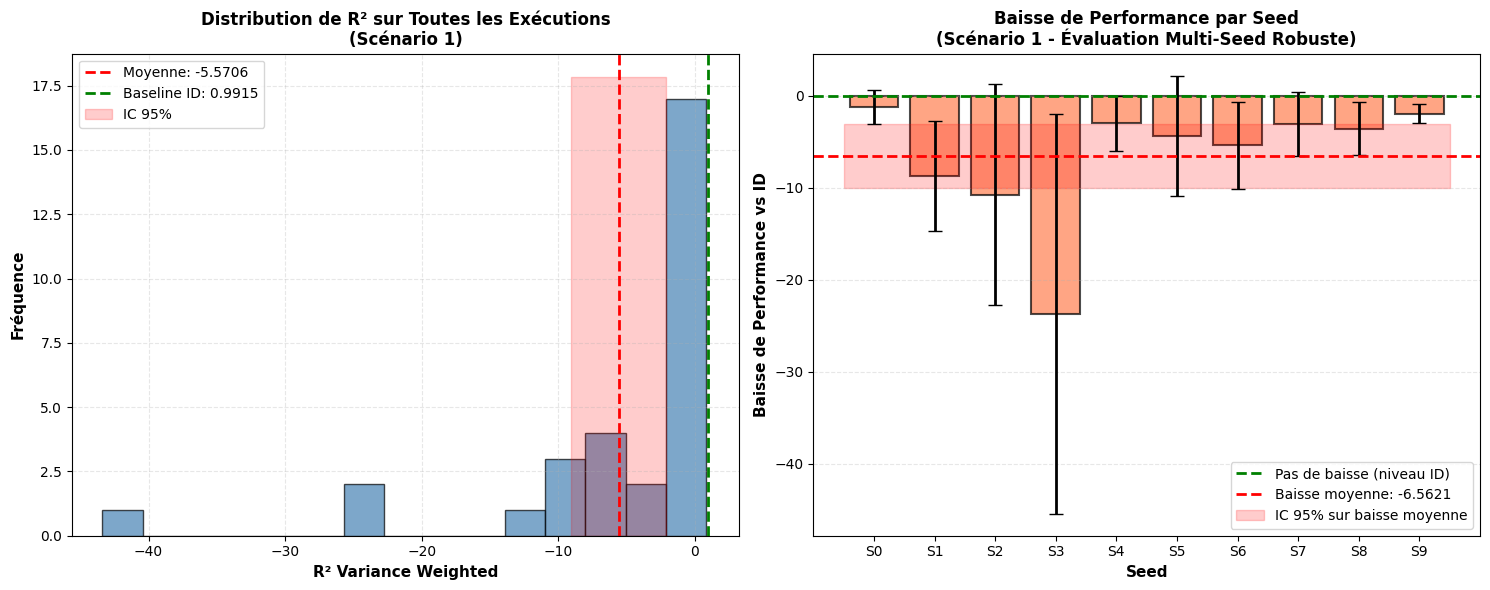


SCÉNARIO 1: RÉSULTATS DÉTAILLÉS PAR SEED
     R² Variance Weighted                           Performance Drop         
                     mean      std      min     max             mean      std
Seed                                                                         
0                 -0.2550   1.8566  -2.3988  0.8235          -1.2465   1.8566
1                 -7.6814   5.9831 -12.1041 -0.8736          -8.6729   5.9831
2                 -9.7475  11.9823 -23.1886 -0.1846         -10.7390  11.9823
3                -22.7278  21.7231 -43.3858 -0.0770         -23.7193  21.7231
4                 -1.9967   3.0257  -5.4170  0.3307          -2.9882   3.0257
5                 -3.3737   6.5649 -10.9536  0.5018          -4.3652   6.5649
6                 -4.3747   4.7433  -9.1273  0.3592          -5.3662   4.7433
7                 -2.0474   3.4465  -6.0270 -0.0319          -3.0389   3.4465
8                 -2.5716   2.8563  -5.8693 -0.8736          -3.5631   2.8563
9                 -0.9

In [41]:
# Visualisation du Scénario 1 avec Intervalles de Confiance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1: Distribution de R² sur toutes les exécutions
ax = axes[0]
ax.hist(ood1_df['R² Variance Weighted'], bins=15, alpha=0.7, color='steelblue', 
        edgecolor='black', density=False)
ax.axvline(mean_r2, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_r2:.4f}')
ax.axvline(ID_r2, color='green', linestyle='--', linewidth=2, label=f'Baseline ID: {ID_r2:.4f}')
ax.fill_betweenx([0, ax.get_ylim()[1]], mean_r2 - ci_95, mean_r2 + ci_95, 
                  alpha=0.2, color='red', label='IC 95%')
ax.set_xlabel('R² Variance Weighted', fontsize=11, fontweight='bold')
ax.set_ylabel('Fréquence', fontsize=11, fontweight='bold')
ax.set_title('Distribution de R² sur Toutes les Exécutions\n(Scénario 1)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, linestyle='--')

# Graphique 2: Baisse de performance par seed
ax = axes[1]
seed_means = ood1_df.groupby('Seed')['Performance Drop'].mean()
seed_stds = ood1_df.groupby('Seed')['Performance Drop'].std()

x_pos = np.arange(len(seed_means))
ax.bar(x_pos, seed_means, yerr=seed_stds, alpha=0.7, color='coral', 
       edgecolor='black', linewidth=1.5, capsize=5, error_kw={'linewidth': 2})
ax.axhline(0, color='green', linestyle='--', linewidth=2, label='Pas de baisse (niveau ID)')
ax.axhline(mean_drop, color='red', linestyle='--', linewidth=2, label=f'Baisse moyenne: {mean_drop:+.4f}')
ax.fill_between([-0.5, len(seed_means) - 0.5], 
                mean_drop - ci_95_drop, mean_drop + ci_95_drop,
                alpha=0.2, color='red', label='IC 95% sur baisse moyenne')

ax.set_xlabel('Seed', fontsize=11, fontweight='bold')
ax.set_ylabel('Baisse de Performance vs ID', fontsize=11, fontweight='bold')
ax.set_title('Baisse de Performance par Seed\n(Scénario 1 - Évaluation Multi-Seed Robuste)', 
             fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'S{i}' for i in range(num_seeds)])
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Tableau résumé
print("\n" + "="*80)
print("SCÉNARIO 1: RÉSULTATS DÉTAILLÉS PAR SEED")
print("="*80)
seed_summary = ood1_df.groupby('Seed').agg({
    'R² Variance Weighted': ['mean', 'std', 'min', 'max'],
    'Performance Drop': ['mean', 'std']
}).round(4)
print(seed_summary)



RÉSULTATS OOD POUR SEED 0 - 11 GRAPHIQUES (UN PAR VARIABLE CIBLE)
Seed 0: Produit caché = Son de maïs
Ensemble d'entraînement: 6276 observations
Ensemble de test: 100 observations



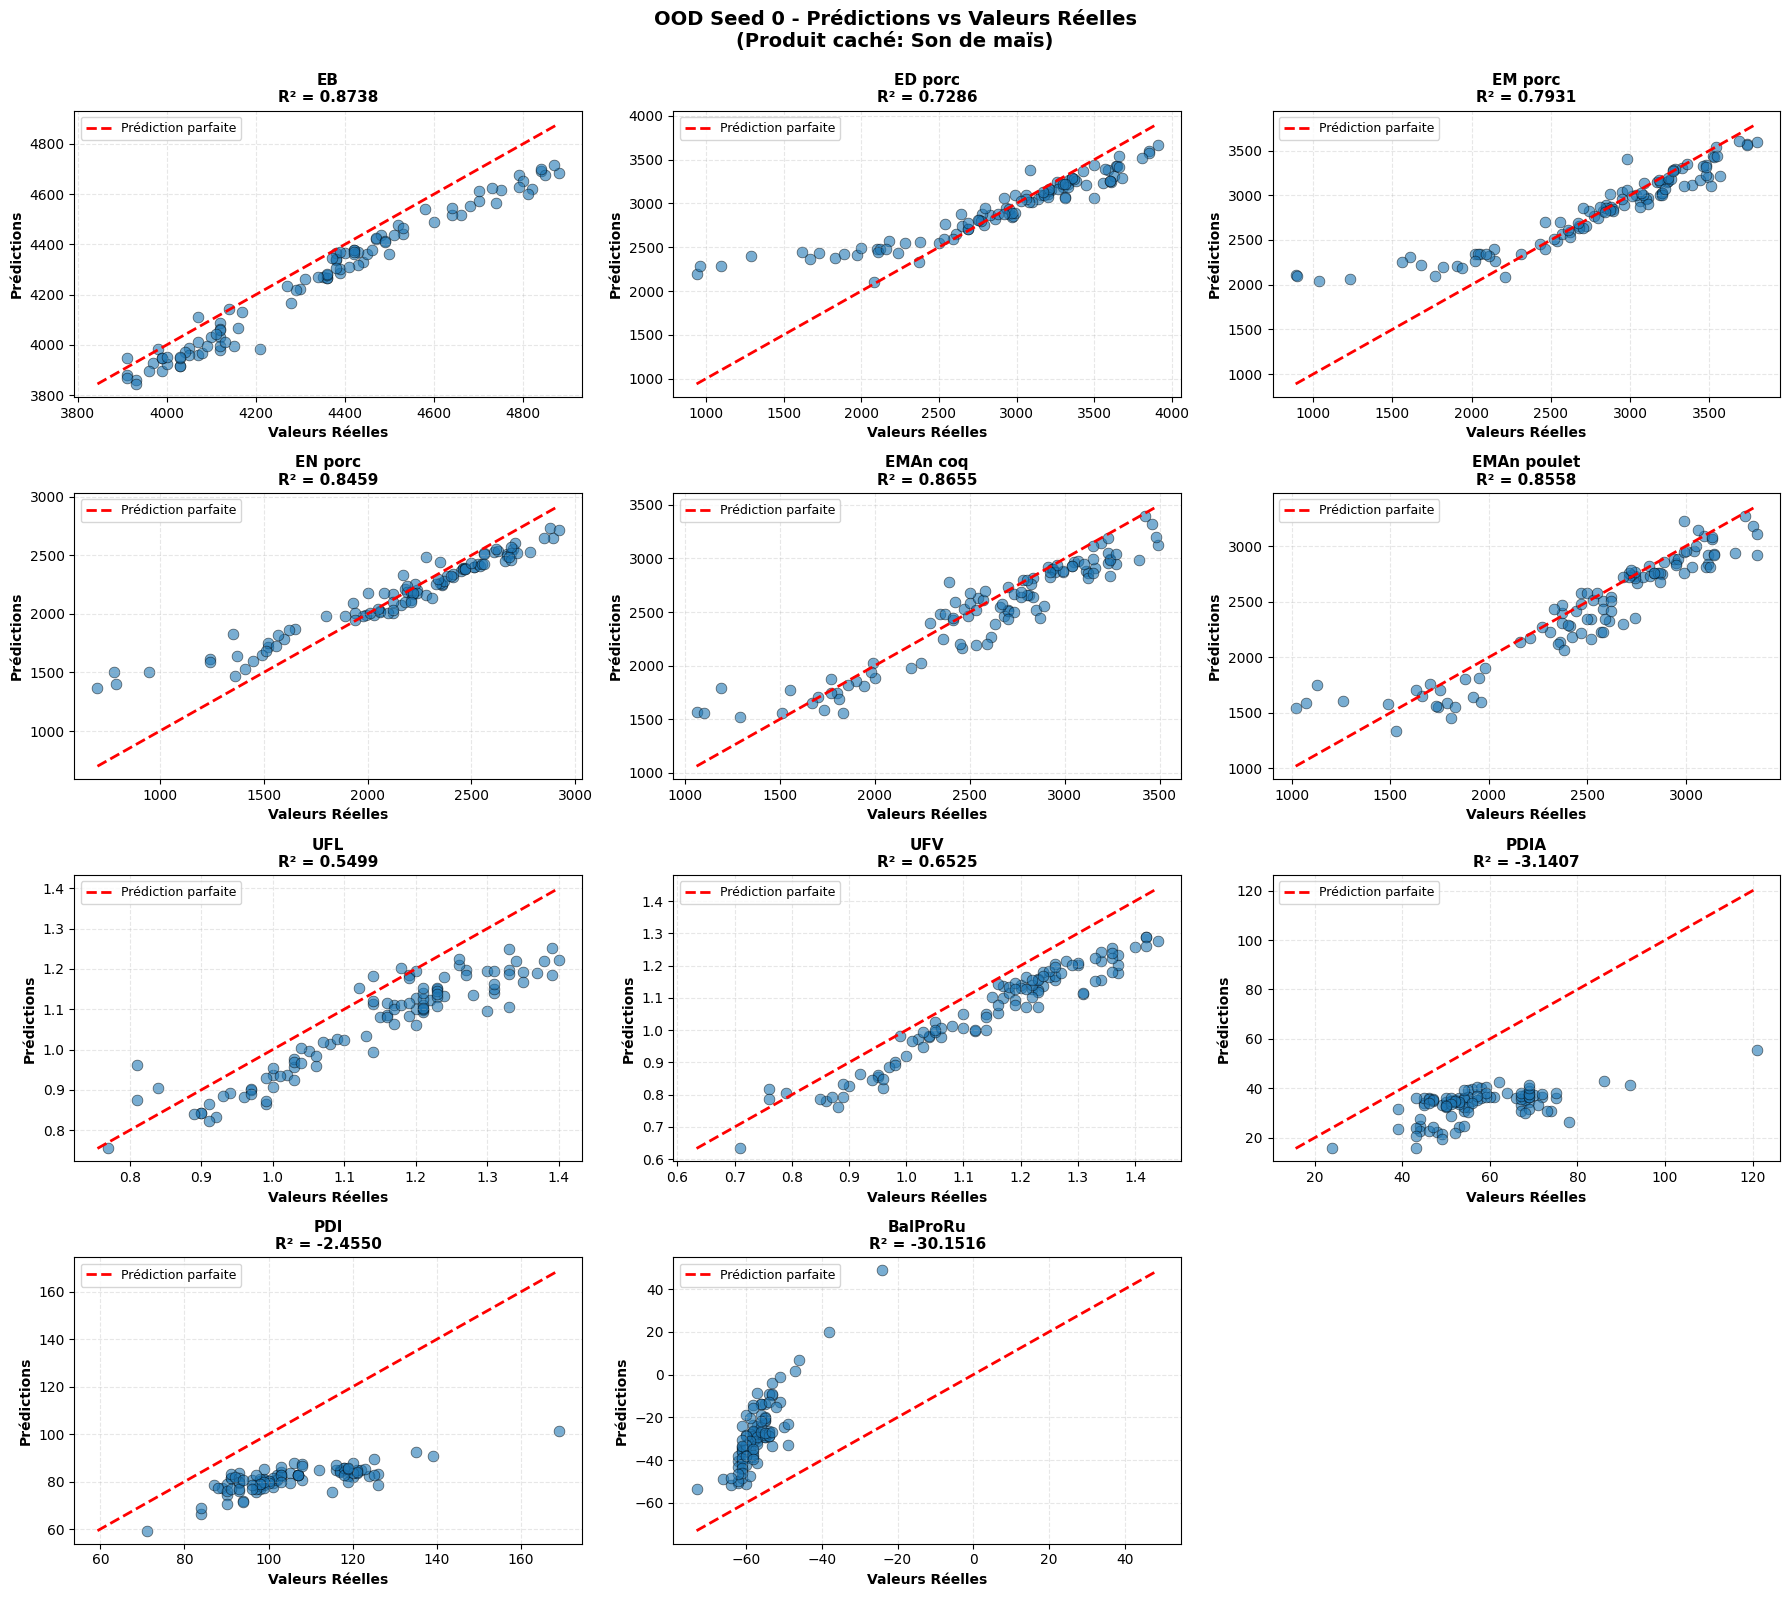


RÉSUMÉ DES PERFORMANCES - SEED 0 PAR VARIABLE CIBLE
Variable Cible         R²  Observations Test
            EB   0.873793                100
       ED porc   0.728554                100
       EM porc   0.793134                100
       EN porc   0.845864                100
      EMAn coq   0.865518                100
   EMAn poulet   0.855800                100
           UFL   0.549945                100
           UFV   0.652520                100
          PDIA  -3.140680                100
           PDI  -2.455014                100
      BalProRu -30.151650                100

R² Moyen (Seed 0): -2.6893
R² Min: -30.1516
R² Max: 0.8738
Écart-type: 9.2212


In [42]:
# Afficher les résultats OOD pour Seed 0 avec les 11 variables cibles - UN GRAPHE PAR VARIABLE CIBLE
from sklearn.metrics import r2_score
import xgboost as xgb

print("\n" + "="*80)
print("RÉSULTATS OOD POUR SEED 0 - 11 GRAPHIQUES (UN PAR VARIABLE CIBLE)")
print("="*80)

seed_idx = 0
rng = np.random.RandomState(seed_idx)

# Sélectionner N produits différents à cacher pour ce seed
products_to_test = rng.choice(unique_noms, size=products_per_seed, replace=False)

# Récupérer le premier produit testé pour ce seed
nom_to_hide = products_to_test[0]

X_train_ood = data[data['Nom'] != nom_to_hide][vars_expl].reset_index(drop=True)
X_test_ood = data[data['Nom'] == nom_to_hide][vars_expl].reset_index(drop=True)
y_train_ood = data[data['Nom'] != nom_to_hide][vars_cibles].reset_index(drop=True)
y_test_ood = data[data['Nom'] == nom_to_hide][vars_cibles].reset_index(drop=True)

print(f"Seed 0: Produit caché = {nom_to_hide}")
print(f"Ensemble d'entraînement: {len(X_train_ood)} observations")
print(f"Ensemble de test: {len(X_test_ood)} observations\n")

# Créer une grille 4x3 pour les 11 variables cibles (12 sous-graphes)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

# Entrainer un modèle pour chaque variable cible et afficher les résultats
results_seed0 = []

for idx, target_var in enumerate(vars_cibles):
    try:
        # Entraîner le modèle XGBoost pour cette variable cible
        model = xgb.XGBRegressor(random_state=seed_idx, verbose=0)
        model.fit(X_train_ood, y_train_ood[target_var], verbose=False)
        
        # Prédictions
        y_pred = model.predict(X_test_ood)
        y_true = y_test_ood[target_var].values
        
        # Calculer le R² pour cette variable spécifique
        r2 = r2_score(y_true, y_pred)
        
        # Créer le graphique
        ax = axes[idx]
        
        # Scatter plot: valeurs réelles vs prédites
        ax.scatter(y_true, y_pred, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Ajouter la ligne de performance parfaite (y=x)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')
        
        # Obtenir le nom simplifié de la variable
        simple_name = simplified_names.get(target_var, target_var)
        
        ax.set_xlabel('Valeurs Réelles', fontsize=10, fontweight='bold')
        ax.set_ylabel('Prédictions', fontsize=10, fontweight='bold')
        ax.set_title(f'{simple_name}\nR² = {r2:.4f}', 
                    fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
        
        results_seed0.append({
            'Variable Cible': simple_name,
            'R²': r2,
            'Observations Test': len(X_test_ood)
        })
        
    except Exception as e:
        ax = axes[idx]
        ax.set_visible(False)
        print(f"⚠ Erreur pour {target_var}: {str(e)}")

# Masquer le dernier axe inutilisé (nous avons 11 variables mais 12 sous-graphes)
axes[11].set_visible(False)

plt.suptitle(f'OOD Seed 0 - Prédictions vs Valeurs Réelles\n(Produit caché: {nom_to_hide})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../reports/figures/ood_seed0_predictions_vs_reality.png', dpi=300)
plt.show()

# Afficher le résumé des R² pour chaque variable cible
print("\n" + "="*80)
print("RÉSUMÉ DES PERFORMANCES - SEED 0 PAR VARIABLE CIBLE")
print("="*80)
results_df = pd.DataFrame(results_seed0)
print(results_df.to_string(index=False))

print(f"\nR² Moyen (Seed 0): {results_df['R²'].mean():.4f}")
print(f"R² Min: {results_df['R²'].min():.4f}")
print(f"R² Max: {results_df['R²'].max():.4f}")
print(f"Écart-type: {results_df['R²'].std():.4f}")


RÉSULTATS OOD - R² MOYEN PAR VARIABLE CIBLE (10 SEEDS)

Résumé des R² par Variable Cible (moyenne sur 10 seeds):
Variable Cible    R² Moyen  Écart-type  N Observations
            EB    0.051537    0.834971              10
       ED porc  -88.935577  255.607591              10
       EM porc  -86.746631  252.148132              10
       EN porc -154.609418  458.615897              10
      EMAn coq   -5.820732   15.564563              10
   EMAn poulet   -6.128535   18.119965              10
           UFL   -9.543022   20.468036              10
           UFV  -14.357362   34.250489              10
          PDIA  -25.006013   37.520789              10
           PDI  -18.648860   26.840137              10
      BalProRu   -5.646719    8.832032              10


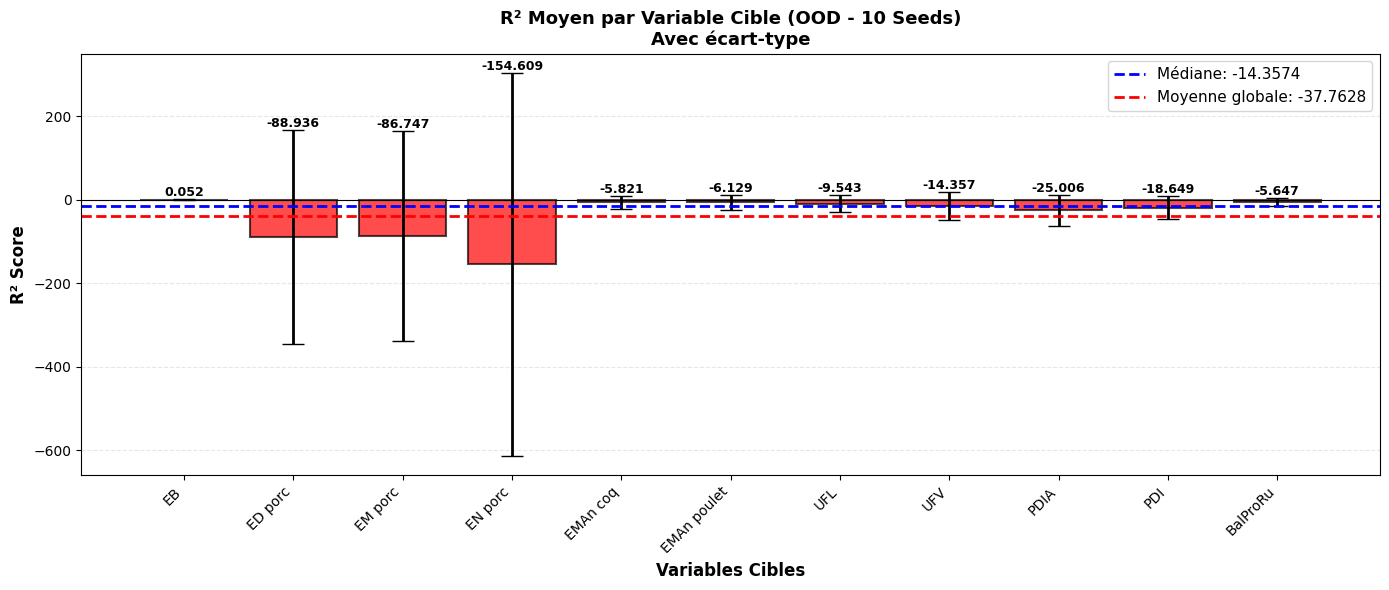


R² global moyen: -37.7628
Écart-type global: 102.6184


In [54]:
# Calculer les R² moyens pour chaque variable cible sur les 10 seeds
print("\n" + "="*80)
print("RÉSULTATS OOD - R² MOYEN PAR VARIABLE CIBLE (10 SEEDS)")
print("="*80)

from sklearn.metrics import r2_score
import xgboost as xgb

# Dictionnaire pour stocker les R² par variable cible et par seed
r2_by_target_by_seed = {var: [] for var in vars_cibles}

for seed_idx in range(num_seeds):
    rng = np.random.RandomState(seed_idx)
    products_to_test = rng.choice(unique_noms, size=products_per_seed, replace=False)
    nom_to_hide = products_to_test[0]
    
    X_train_ood = data[data['Nom'] != nom_to_hide][vars_expl].reset_index(drop=True)
    X_test_ood = data[data['Nom'] == nom_to_hide][vars_expl].reset_index(drop=True)
    y_train_ood = data[data['Nom'] != nom_to_hide][vars_cibles].reset_index(drop=True)
    y_test_ood = data[data['Nom'] == nom_to_hide][vars_cibles].reset_index(drop=True)
    
    if len(X_test_ood) >= 1:
        for target_var in vars_cibles:
            try:
                model = xgb.XGBRegressor(random_state=seed_idx, verbose=0)
                model.fit(X_train_ood, y_train_ood[target_var], verbose=False)
                y_pred = model.predict(X_test_ood)
                y_true = y_test_ood[target_var].values
                r2 = r2_score(y_true, y_pred)
                r2_by_target_by_seed[target_var].append(r2)
            except Exception as e:
                print(f"⚠ Erreur Seed {seed_idx}, {target_var}: {str(e)}")

# Calculer moyennes et écart-types par variable cible
summary_data = []
for target_var in vars_cibles:
    r2_values = r2_by_target_by_seed[target_var]
    if len(r2_values) > 0:
        mean_r2 = np.mean(r2_values)
        std_r2 = np.std(r2_values)
        simple_name = simplified_names.get(target_var, target_var)
        summary_data.append({
            'Variable Cible': simple_name,
            'R² Moyen': mean_r2,
            'Écart-type': std_r2,
            'N Observations': len(r2_values)
        })

summary_df = pd.DataFrame(summary_data)

print("\nRésumé des R² par Variable Cible (moyenne sur 10 seeds):")
print(summary_df.to_string(index=False))

# Créer le bar plot
fig, ax = plt.subplots(figsize=(14, 6))

variables = summary_df['Variable Cible'].values
r2_means = summary_df['R² Moyen'].values
r2_stds = summary_df['Écart-type'].values

# Créer les barres avec couleur basée sur la moyenne de R²
colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0 else 'red' for r2 in r2_means]

bars = ax.bar(range(len(variables)), r2_means, yerr=r2_stds, 
              color=colors, alpha=0.7, edgecolor='black', linewidth=1.5, 
              capsize=8, error_kw={'linewidth': 2, 'elinewidth': 2})

# Ajouter une ligne horizontale à R² = 0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Ajouter une ligne horizontale pour la médiane et la moyenne globale
global_median_r2 = np.median(r2_means)
global_mean_r2 = np.mean(r2_means)
ax.axhline(y=global_median_r2, color='blue', linestyle='--', linewidth=2, label=f'Médiane: {global_median_r2:.4f}')
ax.axhline(y=global_mean_r2, color='red', linestyle='--', linewidth=2, label=f'Moyenne globale: {global_mean_r2:.4f}')

# Ajouter les valeurs de R² moyen sur les barres
for i, (bar, r2_mean, r2_std) in enumerate(zip(bars, r2_means, r2_stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + r2_std,
            f'{r2_mean:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

ax.set_xlabel('Variables Cibles', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('R² Moyen par Variable Cible (OOD - 10 Seeds)\nAvec écart-type', 
             fontsize=13, fontweight='bold')
ax.set_xticks(range(len(variables)))
ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.savefig('../reports/figures/ood_r2_means_all_seeds_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nR² global moyen: {global_mean_r2:.4f}")
print(f"Écart-type global: {np.mean(r2_stds):.4f}")

In [44]:
# Test Statistique Formel: ID vs Scénario 1
print("\n" + "="*80)
print("TEST DE SIGNIFICATIVITÉ STATISTIQUE: ID vs SCÉNARIO 1")
print("="*80)

# Créer une comparaison: pour chaque exécution OOD1, comparer vs ID
# (On utilise la baseline ID comme valeur fixe pour comparer)
ood1_r2_values = ood1_df['R² Variance Weighted'].values
ID_r2_value = metrics_ID['R2_variance_weighted']

# Comparaison appairée (chaque exécution OOD1 vs la baseline ID unique)
# On utilisera un test t sur un seul échantillon sur les différences
differences = ood1_r2_values - ID_r2_value

print(f"\nBaseline ID R²: {ID_r2_value:.4f}")
print(f"R² Moyen Scénario OOD 1: {mean_r2:.4f}")
print(f"Différence Moyenne: {np.mean(differences):+.4f}")
print(f"Écart-type des Différences: {np.std(differences):.4f}")

# Test t de Welch (n'assume pas les variances égales)
t_stat_welch, p_value_welch = stats.ttest_1samp(differences, 0)
print(f"\nTest t sur un seul échantillon de Welch (H0: différence = 0):")
print(f"  t-statistique: {t_stat_welch:.4f}")
print(f"  p-valeur: {p_value_welch:.6f}")
print(f"  Degrés de liberté: {len(differences) - 1}")

# Taille de l'effet (d de Cohen)
cohens_d = np.mean(differences) / np.std(differences)
print(f"\nTaille de l'Effet (d de Cohen): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "négligeable"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "petite"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "moyenne"
else:
    effect_interpretation = "grande"
print(f"  Interprétation: {effect_interpretation}")

# Conclusion
alpha = 0.05
print(f"\nConclusion (α = {alpha}):")
if p_value_welch < alpha:
    print(f"  ✓ Les performances du Scénario 1 SONT significativement différentes d'ID (p = {p_value_welch:.6f})")
else:
    print(f"  ✗ Les performances du Scénario 1 ne sont PAS significativement différentes d'ID (p = {p_value_welch:.6f})")

if np.mean(differences) < 0:
    print(f"  → Le Scénario OOD 1 montre une DÉGRADATION de performance")
else:
    print(f"  → Le Scénario OOD 1 montre une AMÉLIORATION de performance (inattendu)")



TEST DE SIGNIFICATIVITÉ STATISTIQUE: ID vs SCÉNARIO 1

Baseline ID R²: 0.9915
R² Moyen Scénario OOD 1: -5.5706
Différence Moyenne: -6.5621
Écart-type des Différences: 9.5232

Test t sur un seul échantillon de Welch (H0: différence = 0):
  t-statistique: -3.7107
  p-valeur: 0.000872
  Degrés de liberté: 29

Taille de l'Effet (d de Cohen): -0.6891
  Interprétation: moyenne

Conclusion (α = 0.05):
  ✓ Les performances du Scénario 1 SONT significativement différentes d'ID (p = 0.000872)
  → Le Scénario OOD 1 montre une DÉGRADATION de performance


### Résumé des Performances OOD & Visualisation


In [46]:
# Créer comparaison: ID vs OOD Scénario 1 - R² absolus avec écarts-types comparables
comparison_df = pd.DataFrame([
    {"Scénario": "Baseline ID", "R²": mean_r2_id, "Écart-type": std_r2_id, "IC": ci_95_id},
    {"Scénario": "OOD: Cacher 1 Produit", "R²": mean_r2, "Écart-type": std_r2, "IC": ci_95}
])

print("\n" + "="*80)
print("COMPARAISON ID vs OOD SCÉNARIO 1 - R² ABSOLUS")
print("="*80)
print(f"Baseline ID:")
print(f"  R² Moyen: {mean_r2_id:.4f}")
print(f"  Écart-type: {std_r2_id:.4f}")
print(f"  IC 95%: ± {ci_95_id:.4f}")
print(f"  N exécutions: {len(ID_df)}")
print(f"\nScénario OOD 1:")
print(f"  R² Moyen: {mean_r2:.4f}")
print(f"  Écart-type: {std_r2:.4f}")
print(f"  IC 95%: ± {ci_95:.4f}")
print(f"  N exécutions: {len(ood1_df)}")
print(f"\nBaisse de Performance: {mean_r2 - mean_r2_id:+.4f}")
print("\n" + comparison_df.to_string(index=False))



COMPARAISON ID vs OOD SCÉNARIO 1 - R² ABSOLUS
Baseline ID:
  R² Moyen: 0.9908
  Écart-type: 0.0007
  IC 95%: ± 0.0004
  N exécutions: 10

Scénario OOD 1:
  R² Moyen: -5.5706
  Écart-type: 9.6860
  IC 95%: ± 3.4661
  N exécutions: 30

Baisse de Performance: -6.5614

             Scénario       R²  Écart-type       IC
          Baseline ID  0.99080    0.000683 0.000423
OOD: Cacher 1 Produit -5.57056    9.686000 3.466091


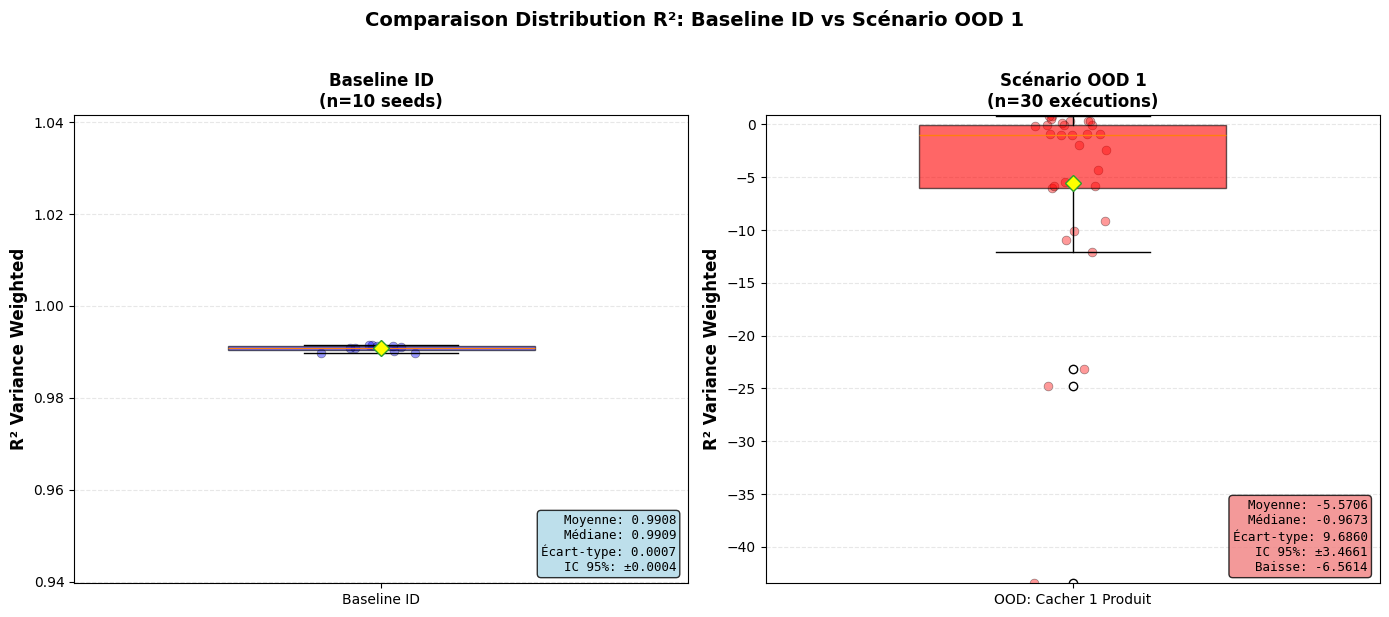

In [49]:
# Visualisation: ID vs OOD Scénario 1 - Graphiques séparés pour clarté
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# GRAPHIQUE GAUCHE: Baseline ID
ax1 = axes[0]
ID_data = ID_df['R² Variance Weighted'].values

bp1 = ax1.boxplot([ID_data], 
                   labels=['Baseline ID'],
                   patch_artist=True,
                   widths=0.5,
                   showmeans=True,
                   meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))

# Colorier la boîte
for patch in bp1['boxes']:
    patch.set_facecolor('blue')
    patch.set_alpha(0.6)

# Ajouter les points individuels avec gigue
x_jitter = np.random.normal(1, 0.04, size=len(ID_data))
ax1.scatter(x_jitter, ID_data, alpha=0.4, s=40, color='blue', edgecolors='black', linewidth=0.5)

ax1.set_ylabel('R² Variance Weighted', fontsize=12, fontweight='bold')
ax1.set_title(f'Baseline ID\n(n={len(ID_df)} seeds)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les stats au graphique ID
ID_stats = f"""Moyenne: {mean_r2_id:.4f}
Médiane: {ID_df['R² Variance Weighted'].median():.4f}
Écart-type: {std_r2_id:.4f}
IC 95%: ±{ci_95_id:.4f}"""

ax1.text(0.98, 0.02, ID_stats, transform=ax1.transAxes, 
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
         family='monospace')

# Définir les limites de l'axe y pour ID
y_min_ID = np.min(ID_data) - 0.05
y_max_ID = np.max(ID_data) + 0.05
ax1.set_ylim([y_min_ID, y_max_ID])

# GRAPHIQUE DROIT: Scénario OOD 1
ax2 = axes[1]
ood_data = ood1_df['R² Variance Weighted'].values

bp2 = ax2.boxplot([ood_data], 
                   labels=['OOD: Cacher 1 Produit'],
                   patch_artist=True,
                   widths=0.5,
                   showmeans=True,
                   meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))

# Colorier la boîte
for patch in bp2['boxes']:
    patch.set_facecolor('red')
    patch.set_alpha(0.6)

# Ajouter les points individuels avec gigue
x_jitter = np.random.normal(1, 0.04, size=len(ood_data))
ax2.scatter(x_jitter, ood_data, alpha=0.4, s=40, color='red', edgecolors='black', linewidth=0.5)

ax2.set_ylabel('R² Variance Weighted', fontsize=12, fontweight='bold')
ax2.set_title(f'Scénario OOD 1\n(n={len(ood1_df)} exécutions)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les stats au graphique OOD
ood_stats = f"""Moyenne: {mean_r2:.4f}
Médiane: {ood1_df['R² Variance Weighted'].median():.4f}
Écart-type: {std_r2:.4f}
IC 95%: ±{ci_95:.4f}
Baisse: {mean_r2 - mean_r2_id:+.4f}"""

ax2.text(0.98, 0.02, ood_stats, transform=ax2.transAxes, 
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
         family='monospace')

# Définir les limites de l'axe y pour OOD
y_min_ood = np.min(ood_data) - 0.05
y_max_ood = np.max(ood_data) + 0.05
ax2.set_ylim([y_min_ood, y_max_ood])

fig.suptitle('Comparaison Distribution R²: Baseline ID vs Scénario OOD 1', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('../reports/figures/ood_comparaison_ID_ood1.png')
plt.show()
